# Load Stuff

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import cv2

In [2]:
classes = {
    0: ("actinic keratoses and intraepithelial carcinomae(Cancer)"),
    1: ("basal cell carcinoma(Cancer)"),
    2: ("benign keratosis-like lesions(Non-Cancerous)"),
    3: ("dermatofibroma(Non-Cancerous)"),
    4: ("melanocytic nevi(Non-Cancerous)"),
    5: ("pyogenic granulomas and hemorrhage(Can lead to cancer)"),
    6: ("melanoma(Cancer)"),
}

In [3]:
# Load train and test set into X and Y
train_path = "dataset\hmnist_28_28_RGB_train.csv"
test_path = "dataset\hmnist_28_28_RGB_test.csv"

train_set = pd.read_csv(train_path)
test_set = pd.read_csv(test_path)

y_train = train_set['label']
x_train = train_set.drop(columns=['label'])
x_train=np.array(x_train).reshape(-1,28,28,3)

y_test = test_set['label']
x_test = test_set.drop(columns=['label'])
x_test=np.array(x_test).reshape(-1,28,28,3)


In [4]:
# Load the pre-trained model
model = keras.models.load_model('best_model.h5')
model.trainable = True
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
score = model.evaluate(x_test, y_test, verbose=0, batch_size=1)
print('Test loss:', score[0])
print('Test accuracy (%):', 100*score[1])






Test loss: 1.2572473287582397
Test accuracy (%): 72.59111404418945


In [5]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0

# Attack

### Function to Make Pertubated Images 

In [6]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_compromised_image(image, epsilon, model_to_attack):
  image = tf.convert_to_tensor(image.reshape((1, 28, 28, 3)), dtype=tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model_to_attack(image)
    label = tf.argmax(prediction, axis=1)
    loss = loss_object(label, prediction)

  gradient = tape.gradient(loss, image)
  perturbations = tf.sign(gradient)

  adversarial_image = image + epsilon*perturbations
  return adversarial_image


### Test Out Attack

1/1 [==============================] - 0s 211ms/step


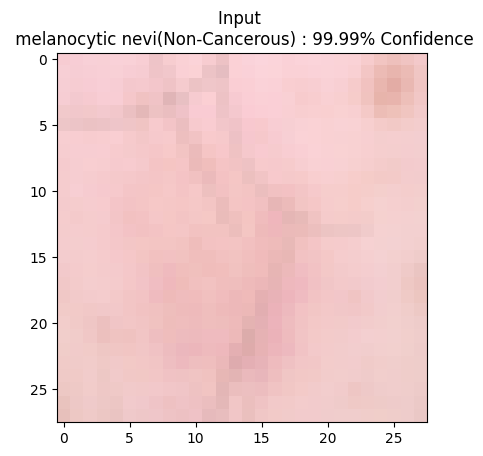

1/1 [==============================] - 0s 24ms/step


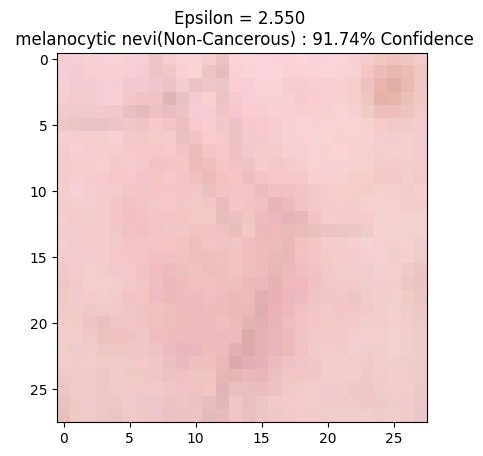

1/1 [==============================] - 0s 23ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


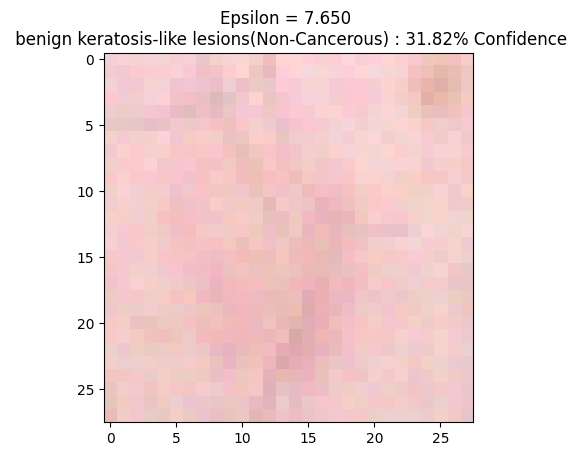

1/1 [==============================] - 0s 25ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


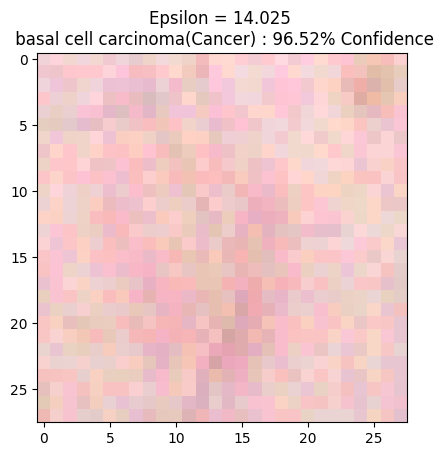

In [7]:
def display_images(new_image, description):
  #  Display the given image along with its predicted label and confidence.
  pred = model.predict(new_image)
  label = np.argmax(pred, axis=1)[0]
  label = classes[label]
  confidence = np.max(pred, axis=1)[0]
  plt.figure()
  plt.imshow(new_image[0]*0.5/255+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
  plt.show()

epsilons = np.array([0, 0.01, 0.03, 0.055])*255
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = create_compromised_image(x_test[0], eps, model)
  display_images(adv_x, descriptions[i])

### Test Attack on multiple images and plot the accuracy for different epsilons

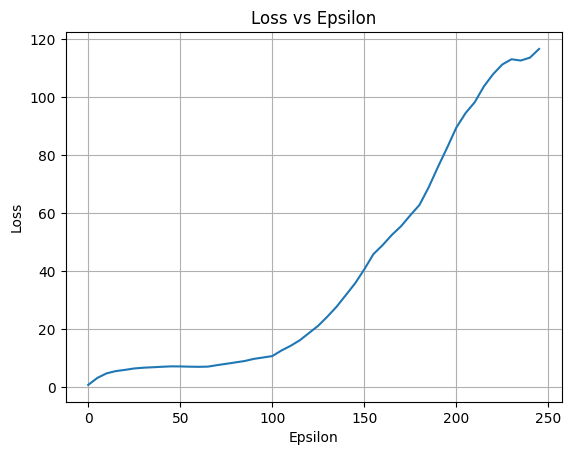

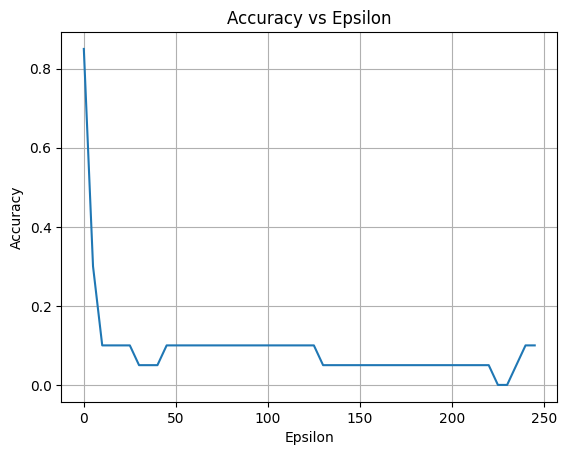

In [8]:
epsilon = np.linspace(0, 245, 50)

length = 20

test_loss = []
test_acc = []

for eps in epsilon:
    x_test_compromised = []
    for i, img in enumerate(x_test[:length]):
        adv_x = create_compromised_image(img, eps, model)[0].numpy()
        x_test_compromised.append(adv_x)

    x_test_compromised = np.array(x_test_compromised)
    score = model.evaluate(x_test_compromised, y_test[:length], verbose=0, batch_size=1)
    test_loss.append(score[0])
    test_acc.append(score[1])

plt.figure()
plt.plot(epsilon, test_loss)
plt.title('Loss vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.figure()
plt.plot(epsilon, test_acc)
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

### Make Equivalent CSV file of Pertubated Images

In [30]:
def make_and_store_pertubated_images(og_path, comp_path, epsilon):

    og_df=pd.read_csv(og_path)

    labels = og_df['label']
    og_img = og_df.drop(columns=['label'])
    og_img=np.array(og_img).reshape(-1,28,28,3)

    # Create compromised dataset
    compromised_img = []
    epsilon = 0.055
    for i, img in enumerate(og_img):
        adv_x = create_compromised_image(img, epsilon*255, model).numpy()
        compromised_img.append(adv_x)
    compromised_img = np.array(compromised_img)

    # Evaluate compromised dataset
    score = model.evaluate(compromised_img, labels, verbose=0, batch_size=1)
    print('Test loss:', score[0])
    print('Test accuracy (%):', 100*score[1])

    # Save as csv
    compromised_img = compromised_img.reshape(-1, 28*28*3)
    compromised_img_with_labels = np.concatenate((compromised_img, np.array(labels)[:, None]), axis=1)
    comp_df = pd.DataFrame(compromised_img_with_labels)
    comp_df.columns = og_df.columns
    comp_df.to_csv(comp_path, index=False)

# og_path = 'dataset\\hmnist_28_28_RGB_train.csv'
# comp_path = 'dataset\\hmnist_28_28_RGB_train_0e055.csv'
# make_and_store_pertubated_images(og_path, comp_path, 0.055)

# og_path = 'dataset\\hmnist_28_28_RGB_test.csv'
# comp_path = 'dataset\\hmnist_28_28_RGB_test_0e055.csv'
# make_and_store_pertubated_images(og_path, comp_path, 0.055)

Test loss: 4.892673492431641
Test accuracy (%): 10.022466629743576
Test loss: 4.6564507484436035
Test accuracy (%): 13.629555702209473


# Defence

### Load and Mix Pertubated Images With Normal images

In [9]:
comp_train_path = "dataset\\hmnist_28_28_RGB_train_0e055.csv"
comp_test_path = "dataset\\hmnist_28_28_RGB_test_0e055.csv"

og_train_df = pd.read_csv(train_path)
comp_train_df = pd.read_csv(comp_train_path)

og_test_df = pd.read_csv(test_path)
comp_test_df = pd.read_csv(comp_test_path)


# Merge the two datasets
merged_train_df = pd.concat([og_train_df, comp_train_df], ignore_index=True)
merged_test_df = pd.concat([og_test_df, comp_test_df], ignore_index=True)

# Shuffle the datasets
merged_train_df = merged_train_df.sample(frac=1).reset_index(drop=True)
merged_test_df = merged_test_df.sample(frac=1).reset_index(drop=True)

# Print the number of samples in each dataset
print("Number of samples in train set: {}".format(len(merged_train_df)))
print("Number of samples in test set: {}".format(len(merged_test_df)))

# Prepare images and labels
y_train_merged = merged_train_df['label']
x_train_merged = merged_train_df.drop(columns=['label'])

y_test_merged = merged_test_df['label']
x_test_merged = merged_test_df.drop(columns=['label'])

# Oversample the train set
oversample = RandomOverSampler()
x_train_merged,y_train_merged  = oversample.fit_resample(x_train_merged,y_train_merged)

# Reshape the train and test sets
x_train_merged = np.array(x_train_merged).reshape(-1,28,28,3)
x_test_merged = np.array(x_test_merged).reshape(-1,28,28,3)

Number of samples in train set: 16024
Number of samples in test set: 4006


### Data Augmentation for Training

In [11]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model_defended.h5',
                                              monitor='val_accuracy', 
                                              mode='max',
                                              verbose=1,
                                              save_best_only=True)

defended_model = tf.keras.models.clone_model(model)
defended_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

defended_model.fit(x_train_merged, y_train_merged, epochs=10, batch_size=32, validation_split=0.2, callbacks=[callback])
defended_model = keras.models.load_model('best_model_defended.h5')

Epoch 1/10
1871/1871 [==============================] - ETA: 0s - loss: 0.9237 - accuracy: 0.6670
Epoch 1: val_accuracy improved from -inf to 0.40364, saving model to best_model_defended.h5
1871/1871 [==============================] - 38s 19ms/step - loss: 0.9237 - accuracy: 0.6670 - val_loss: 1.4825 - val_accuracy: 0.4036
Epoch 2/10
   1/1871 [..............................] - ETA: 30s - loss: 0.4359 - accuracy: 0.9062

C:\Users\zengo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1869/1871 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8791
Epoch 2: val_accuracy improved from 0.40364 to 0.44453, saving model to best_model_defended.h5
1871/1871 [==============================] - 32s 17ms/step - loss: 0.3543 - accuracy: 0.8791 - val_loss: 1.5586 - val_accuracy: 0.4445
Epoch 3/10
1868/1871 [============================>.] - ETA: 0s - loss: 0.2399 - accuracy: 0.9192
Epoch 3: val_accuracy improved from 0.44453 to 0.53428, saving model to best_model_defended.h5
1871/1871 [==============================] - 31s 17ms/step - loss: 0.2399 - accuracy: 0.9192 - val_loss: 1.2327 - val_accuracy: 0.5343
Epoch 4/10
1868/1871 [============================>.] - ETA: 0s - loss: 0.1833 - accuracy: 0.9382
Epoch 4: val_accuracy improved from 0.53428 to 0.54892, saving model to best_model_defended.h5
1871/1871 [==============================] - 31s 17ms/step - loss: 0.1831 - accuracy: 0.9383 - val_loss: 0.9785 - val_accuracy: 0.5489
Epoch 5/10
1870/1871 [=====

### Filter Input Defence

In [12]:
def average_filter(img):
    kernel = np.ones((2,2),np.float32)/4
    return cv2.filter2D(img,-1,kernel)

### Test Defended Model 

In [13]:
print('Original dataset:')
score_og = model.evaluate(x_test, y_test, verbose=0, batch_size=1)
score_defend = defended_model.evaluate(x_test, y_test, verbose=0, batch_size=1)
score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
print(score_df)


y_test_compromised = comp_test_df['label']
x_test_compromised = comp_test_df.drop(columns=['label'])
x_test_compromised = np.array(x_test_compromised).reshape(-1,28,28,3)
print('\nCompromised dataset:')
score_og = model.evaluate(x_test_compromised, y_test_compromised, verbose=0, batch_size=1)
score_defend = defended_model.evaluate(x_test_compromised, y_test_compromised, verbose=0, batch_size=1)
score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
print(score_df)


print('\nMerged dataset:')
score_og = model.evaluate(x_test_merged, y_test_merged, verbose=0, batch_size=1)
score_defend = defended_model.evaluate(x_test_merged, y_test_merged, verbose=0, batch_size=1)
score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
print(score_df)


x_test_compromised_filtered = np.array([average_filter(img) for img in x_test_compromised])
print('\nCompromised dataset filtered:')
score_og = model.evaluate(x_test_compromised_filtered, y_test_compromised, verbose=0, batch_size=1)
score_defend = defended_model.evaluate(x_test_compromised_filtered, y_test_compromised, verbose=0, batch_size=1)
score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
print(score_df)

Original dataset:
          Original  Defended
Loss      1.257247  1.295962
Accuracy  0.725911  0.695956

Compromised dataset:
          Original  Defended
Loss      4.656451  1.441336
Accuracy  0.136296  0.671493

Merged dataset:
          Original  Defended
Loss      2.956839  1.368646
Accuracy  0.431103  0.683724

Compromised dataset filtered:
          Original  Defended
Loss      3.067587  1.316880
Accuracy  0.269596  0.714928
